In [19]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel,laplacian_kernel


from keras import backend as K
import tensorflow as tf
from scipy import stats

from keras.engine.input_layer import Input
from keras.models import Sequential, Model
from keras.layers.core import Dropout
from keras.layers import concatenate,Dense
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import L1L2, l2, l1, l1_l2
from keras.initializers import Constant,RandomNormal
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed, GRU
from keras.layers import Lambda, Reshape, BatchNormalization
from keras.backend import slice
from keras import optimizers
from keras.layers.advanced_activations import ELU

In [20]:
#load data
dfw=np.load("edinburgh_24.npy")
def load_parameters(case):
    parameters = \
    {
         'd1': \
             (
              (10, 10, 5), 
              (0, 635, 0, 460, 0, 50),
              1,
              0.01,
              0.001,
              0.004
            ),

        }

    return parameters[case]

cell_resolution, cell_max_min, skip, thresh, gamma, gamma2 = load_parameters('d1')


def calc_grid_auto(cell_resolution, max_min):
    x_min, x_max = max_min[0], max_min[1]
    y_min, y_max = max_min[2], max_min[3]
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, cell_resolution[0]), 
                         np.arange(y_min, y_max, cell_resolution[1]))
    grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
    #grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
    print(xx.shape)
    print(yy.shape)
    return grid

grid = calc_grid_auto(cell_resolution, cell_max_min)
zz=np.arange(cell_max_min[4], cell_max_min[5], cell_resolution[2])

(46, 64)
(46, 64)


In [21]:
c=1 # Dimension of output
m=5 # number of distributions
seq_length=6 # length of sequence

# Various MDN loss funct5ions. Based on implementation provided with Brando, 2017
def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max
def elu_modif(x, a=1.):
    return ELU(alpha=a)(x)+1.+1e-8


def mean_log_vMsingle(y_true,parameters):
    components = K.reshape(parameters,[-1, c + 1, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    exponent =  float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(tf.math.bessel_i0(sigma)) \
    + sigma*K.sum(K.cos((K.expand_dims(y_true,2) - mu)), axis=1)    
    log_vm = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_vm)
    return res

def mean_log_vMmulti(y_true,parameters):
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:,:c, :]
    sigma = components[:, c, :]
    alpha = components[:,c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    exponent =  K.log(alpha) -float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(tf.math.bessel_i0(sigma)) \
    + sigma*K.sum(K.cos((K.expand_dims(y_true,2) - mu)), axis=1)    
    log_vm = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_vm)
    return res

In [22]:
kernelNumber=(grid.shape[0])
inputSize = kernelNumber
inputlayer = Input(name='input', shape=(zz.shape[0], inputSize,))

L1=LSTM(40*m,return_sequences=False)(inputlayer)

x1=Dense(output_dim=m)(L1)

x2=Dense(output_dim=m,activation=elu_modif,kernel_regularizer=l2(0.005))(L1)

x3=Dense(output_dim=m,activation='softmax',kernel_regularizer=l1_l2(l1=0.001,l2=0.001))(L1)

out=concatenate([x1,x2,x3])
model = Model(inputs=inputlayer, outputs=out)
model.compile(optimizer='rmsprop',loss=mean_log_vMmulti)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=5)`
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation=<function ..., units=5, kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
import math
batchsize=2000
epochs=20
training_ds=dfw
iterations=int(math.ceil(training_ds.shape[0])/batchsize)

for i in range(0, iterations):

    ttdf=np.concatenate((training_ds[batchsize*i:batchsize*(i+1),:2],training_ds[batchsize*i:batchsize*(i+1),3].reshape((-1,1))),axis=1)
    x_ar_s  =  rbf_kernel(training_ds[batchsize*i:batchsize*(i+1),:2], grid, gamma = gamma)
    #qpoints = np.repeat(zz.reshape((1,-1)), ttdf.shape[0], axis=0)
    #x_ar_t  =  rq(ttdf[:,2].reshape((-1,1)), qpoints)
    #x_ar_t  =  laplacian_kernel(ttdf[:,2].reshape((-1,1)), zz.reshape((-1,1)), gamma = gamma2)
    x_ar_t  =  rbf_kernel(training_ds[batchsize*i:batchsize*(i+1),3].reshape((-1,1)), zz.reshape((-1,1)), gamma = gamma2)
    outfeat=x_ar_s[:,None,:]*x_ar_t[:,:,None]
    #outfeat=x_ar_s[:,None,:]*x_ar_t[:,:,None]
    #t_point_r  =  rbf_kernel(ttdf, grid, gamma = gamma)
    #t_point_r = np.swapaxes(t_point_r.reshape((len(t_point_r),-1,seq_length)),1,2)
    #dwt=dfw[batchsize*i:batchsize*(i+1),2].reshape((-1,1))
    #tempor_p=rbf_kernel(dwt,zz.reshape((-1,1)),gamma=gamma2)
    targets=training_ds[batchsize*i:batchsize*(i+1),2]
    #outfeat=t_point_r[:,None,:]*tempor_p[:,:,None]
    model.fit(outfeat, targets, batch_size=512, nb_epoch = epochs, verbose = 1)

In [31]:
model.save_weights("edinb2.h5")

In [34]:
model.load_weights("edinb.h5")

In [35]:
from scipy import special as special
def mix_vm_pdf(alphas,mu,k,x):
    Ik = special.iv(0, k) #Calc the modified Bessel functions
    const = 1/(2*np.pi*Ik)
    return np.sum(alphas*const*np.exp(k*np.cos(x-mu)),axis=1)

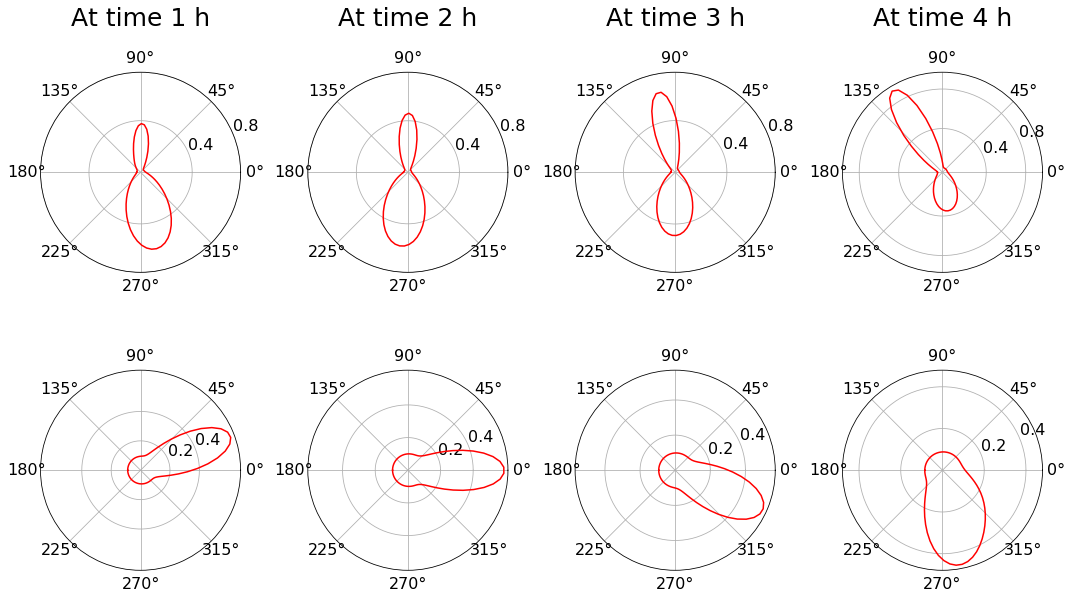

In [36]:
import scipy.stats as stats

s_ll=[[215,200],[315,135]]
ticksl=[[0.4,0.8],[0.2,0.4]]
fig = pl.figure()
fig.set_figheight(13)
fig.set_figwidth(15)
dfd=dfw[:,2].reshape((-1,1))
dfx=dfw[:,0].reshape((-1,1))
dfy=dfw[:,1].reshape((-1,1))
dft=dfw[:,3].reshape((-1,1))
cir=20
cir_t=5
indexn=1
for j in range(0,2):
    s_x,s_y=s_ll[j]
    for i in range(0,4):
        cur_time=10*i
        y_x=s_x
        y_y=s_y
        query_point = (s_x,s_y)
        x_ar_s  =  rbf_kernel(np.array(query_point).reshape((-1,2)), grid, gamma = gamma)
        x_ar_t  =  rbf_kernel(np.array([cur_time]).reshape((-1,1)), zz.reshape((-1,1)), gamma = gamma2)
        outfeat=x_ar_s[:,None,:]*x_ar_t[:,:,None]
        predy = model.predict(outfeat)
        samples=[]
        inpos=dfd[(dfw[:,0]<y_x+cir)&(dfw[:,0]>y_x-cir)&(dfw[:,1]<y_y+cir)& (dfw[:,1]>y_y-cir)&(dfw[:,3]>cur_time-cir_t)&(dfw[:,3]<cur_time+cir_t)]
        sample_number = 1000
        time_pred = predy[0,:]
        comp = np.reshape(time_pred,[-1, c + 2, m])
        mu_pred = comp[:, :c, :]
        sigma_pred = comp[:, c, :]
        alpha_pred = comp[:, c + 1, :]      
        ax = pl.subplot(3,4, indexn, projection='polar')
        if(indexn<5):
            ttl=ax.set_title("At time "+str(indexn)+" h",fontsize=25)
            ttl.set_position([0.5, 1.2])
        indexn+=1       
        x=np.linspace(-np.pi,np.pi,100)
        ax.plot(x, mix_vm_pdf(alpha_pred.reshape((1,-1)),mu_pred.reshape((1,-1)),sigma_pred.reshape((1,-1)),x.reshape((-1,1))),'r')
        ax.set_yticks(ticksl[j])
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)        
pl.tight_layout()


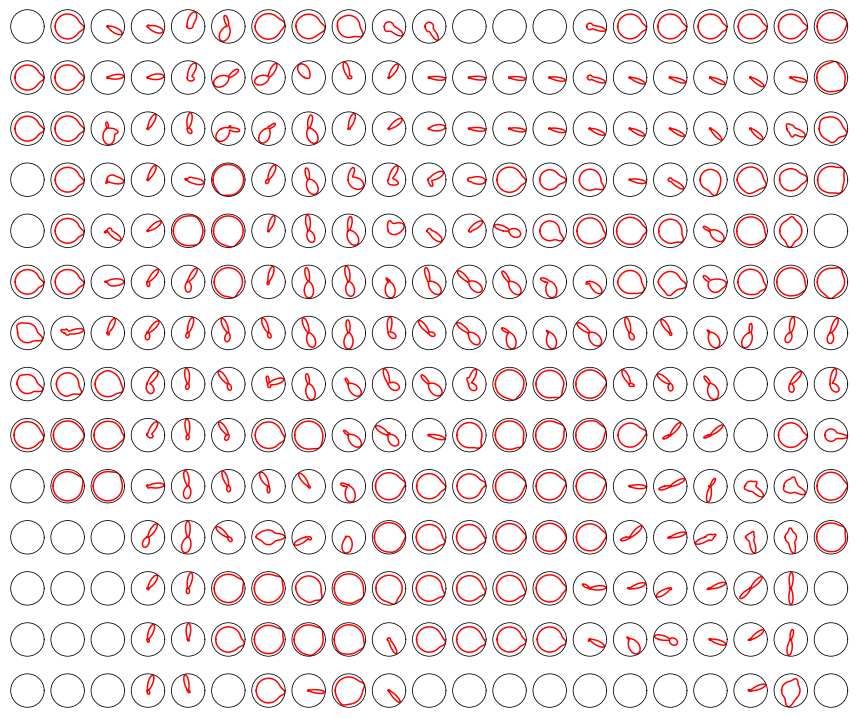

In [37]:
import scipy.stats as stats
fig = pl.figure()
fig.set_figheight(13)
fig.set_figwidth(15)
dfd=dfw[:,2].reshape((-1,1))
dfx=dfw[:,0].reshape((-1,1))
dfy=dfw[:,1].reshape((-1,1))
dft=dfw[:,3].reshape((-1,1))
cir=20
cir_t=10
indexn=1
xp=np.linspace(0,650,21)
yp=np.linspace(0,450,14)
for j in range(0,len(yp)):
    
    for i in range(0,len(xp)):
        s_x,s_y=(xp[i],yp[j])
        cur_time=20 # time step to change
        y_x=s_x
        y_y=s_y
        query_point = (s_x,s_y)
        x_ar_s  =  rbf_kernel(np.array(query_point).reshape((-1,2)), grid, gamma = gamma)
        x_ar_t  =  rbf_kernel(np.array([cur_time]).reshape((-1,1)), zz.reshape((-1,1)), gamma = gamma2)
        outfeat=x_ar_s[:,None,:]*x_ar_t[:,:,None]
        predy = model.predict(outfeat)
        samples=[]
        inpos=dfd[(dfw[:,0]<y_x+cir)&(dfw[:,0]>y_x-cir)&(dfw[:,1]<y_y+cir)& (dfw[:,1]>y_y-cir)]
        sample_number = 5000
        time_pred = predy[0,:]
        comp = np.reshape(time_pred,[-1, c + 2, m])
        mu_pred = comp[:, :c, :]
        sigma_pred = comp[:, c, :]
        alpha_pred = comp[:, c + 1, :]
        samples_alphas=np.random.choice(m, sample_number, p=alpha_pred.reshape((m,)))
        for sample_component in samples_alphas:
            mean = mu_pred[0][0][sample_component]
            sd = sigma_pred[0][sample_component]
            sample = np.random.vonmises(mean,sd,1)[0]
            samples.append(sample)
        density = stats.gaussian_kde(np.array(samples))
       
        ax = pl.subplot(len(yp),len(xp), indexn, projection='polar')
        
        indexn+=1
        
        x=np.linspace(-np.pi,np.pi,100)
        if(len(inpos)>10):
            ax.plot(x, mix_vm_pdf(alpha_pred.reshape((1,-1)),mu_pred.reshape((1,-1)),sigma_pred.reshape((1,-1)),x.reshape((-1,1))),'r')
        else:
            ax.plot('r')

        ax.set_xticks([])
        ax.set_yticks([])


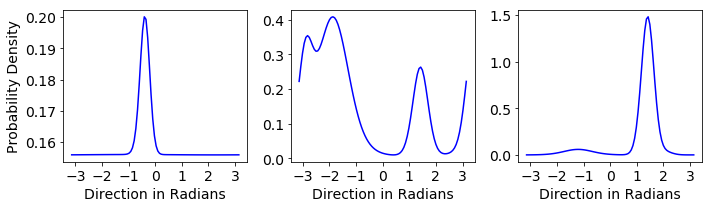

In [38]:
import scipy.stats as stats
s_ll=[[150,150],[400,150],[200,150]] # coordinates
ticksl=[[0.4,0.8,1.2],[0.5,1,1.5],[0.2,0.4,0.6]]
fig = pl.figure()
fig.set_figheight(3)
fig.set_figwidth(10)
dfd=dfw[:,2].reshape((-1,1))
dfx=dfw[:,0].reshape((-1,1))
dfy=dfw[:,1].reshape((-1,1))
dft=dfw[:,3].reshape((-1,1))
cir=20
cir_t=5
indexn=1
for j in range(0,len(s_ll)):
    s_x,s_y=s_ll[j]
    for i in range(0,1):
        cur_time=25 #Time step
        y_x=s_x
        y_y=s_y
        query_point = (s_x,s_y)
        x_ar_s  =  rbf_kernel(np.array(query_point).reshape((-1,2)), grid, gamma = gamma)
        x_ar_t  =  rbf_kernel(np.array([cur_time]).reshape((-1,1)), zz.reshape((-1,1)), gamma = gamma2)
        outfeat=x_ar_s[:,None,:]*x_ar_t[:,:,None]
        predy = model.predict(outfeat)
        samples=[]
        inpos=dfd[(dfw[:,0]<y_x+cir)&(dfw[:,0]>y_x-cir)&(dfw[:,1]<y_y+cir)& (dfw[:,1]>y_y-cir)&(dfw[:,3]>cur_time-cir_t)&(dfw[:,3]<cur_time+cir_t)]
        sample_number = 1000
        time_pred = predy[0,:]
        comp = np.reshape(time_pred,[-1, c + 2, m])
        mu_pred = comp[:, :c, :]
        sigma_pred = comp[:, c, :]
        alpha_pred = comp[:, c + 1, :]
        samples_alphas=np.random.choice(m, sample_number, p=alpha_pred.reshape((m,)))
        for sample_component in samples_alphas:
            mean = mu_pred[0][0][sample_component]
            sd = sigma_pred[0][sample_component]
            sample = np.random.vonmises(mean,sd,1)[0]
            samples.append(sample)
        density = stats.gaussian_kde(np.array(samples))
 
        ax = pl.subplot(1,len(s_ll), indexn)
        if(indexn==1):
            ax.set_ylabel("Probability Density",fontsize=14)
        indexn+=1
        
        x=np.linspace(-np.pi,np.pi,100)
        ax.plot(x, mix_vm_pdf(alpha_pred.reshape((1,-1)),mu_pred.reshape((1,-1)),sigma_pred.reshape((1,-1)),x.reshape((-1,1))),'b')
        ax.set_xticks(np.linspace(-3,3,7))
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.set_xlabel("Direction in Radians",fontsize=14)

pl.tight_layout()